In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
# sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
from ADlasso2 import AD2_w_utils_lossdiff as ad

## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [2]:
os.chdir('/home/jovyan/work/GitHub/EvanPys/Progress/PBMC_Zheng/Leiden_HVG_PreLect/tuning_result')

In [3]:
def ignore_section_lambda_decision(tuning_dict, celltype, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
        
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] == 0:
            cut_idx = i
            print(cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0
        plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")
        ax2.set_ylim(bottom=0.5, top=None)
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    opt_lmbd, fig = ad.lambda_decision(trimmed_tuning, k=2, savepath=output_dir + f'{celltype}_lambda_decision_trimmed.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, savepath=output_dir + f'{celltype}_lambda_decision_all.png')

    return opt_lmbd, feature_no_celltype

In [4]:
opt_lmbd_dict = {}
feature_no_dict = {}


Cell type: Leiden_0
Optimal lambda: 0.0010000000000000002
Feature no: 91
Cell type: Leiden_1
Optimal lambda: 0.003162277660168382
Feature no: 21
Cell type: Leiden_2
Optimal lambda: 0.0006812920690579617
Feature no: 142
Cell type: Leiden_3
Optimal lambda: 0.0006812920690579617
Feature no: 91
Cell type: Leiden_4
Optimal lambda: 0.00046415888336127795
Feature no: 127
Cell type: Leiden_5
Optimal lambda: 0.006812920690579613
Feature no: 17
Cell type: Leiden_6
Optimal lambda: 0.004641588833612781
Feature no: 22
Cell type: Leiden_7
Optimal lambda: 0.006812920690579613
Feature no: 11
Cell type: Leiden_8
24
Optimal lambda: 0.004641588833612781
Feature no: 7
Cut: 0.10000000000000002
Cell type: Leiden_9
Optimal lambda: 0.006812920690579613
Feature no: 8
Cell type: Leiden_10
23


/home/jovyan/work/GitHub/EvanPys/Progress/ADlasso2/AD2_w_utils_lossdiff.py:960: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize = (fig_width, fig_height))


Optimal lambda: 0.014677992676220709
Feature no: 4
Cut: 0.0681292069057962
Cell type: Leiden_11
21
Optimal lambda: 0.006812920690579613
Feature no: 5
Cut: 0.0316227766016838
Cell type: Leiden_12
Optimal lambda: 0.02154434690031885
Feature no: 2
Cell type: Leiden_13
23
Optimal lambda: 0.010000000000000004
Feature no: 2
Cut: 0.0681292069057962
Cell type: Leiden_14
22
Optimal lambda: 0.006812920690579613
Feature no: 7
Cut: 0.04641588833612786
Cell type: Leiden_15
23
Optimal lambda: 0.010000000000000004
Feature no: 5
Cut: 0.0681292069057962


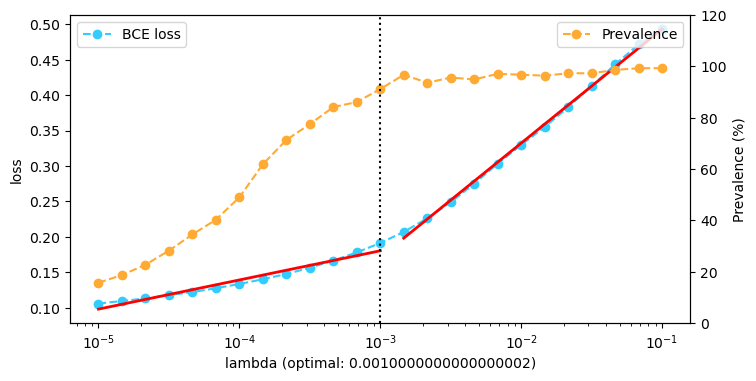

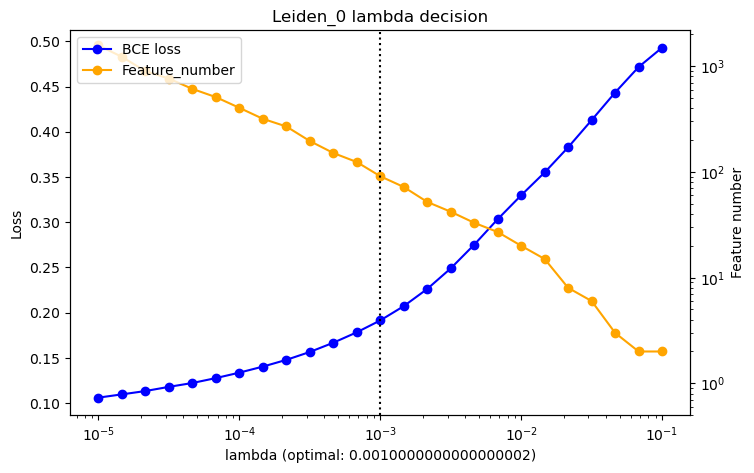

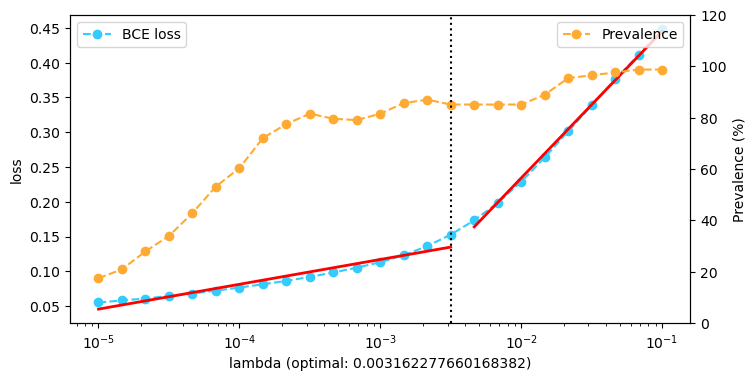

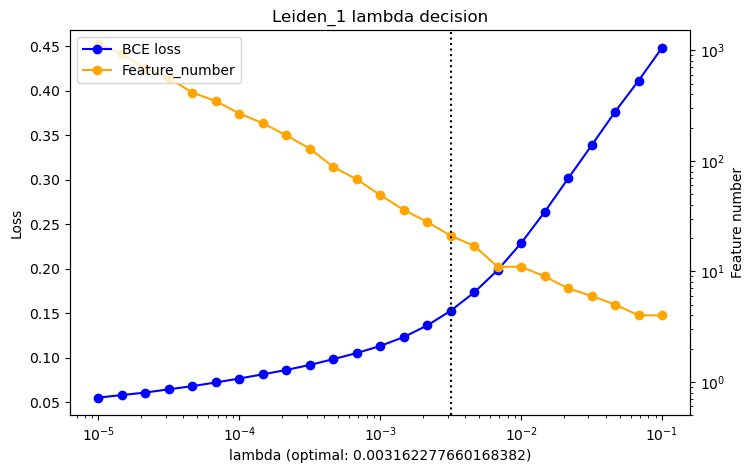

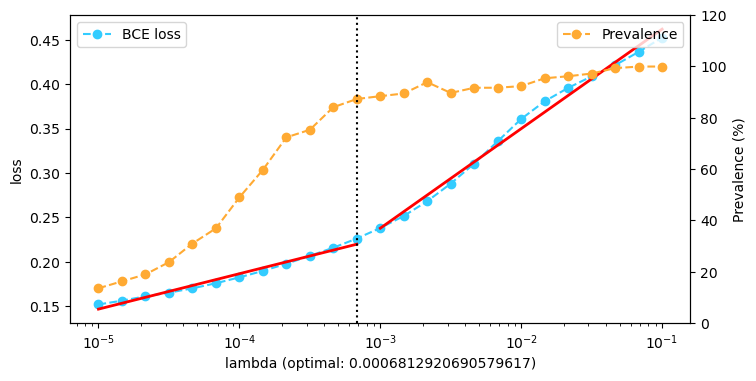

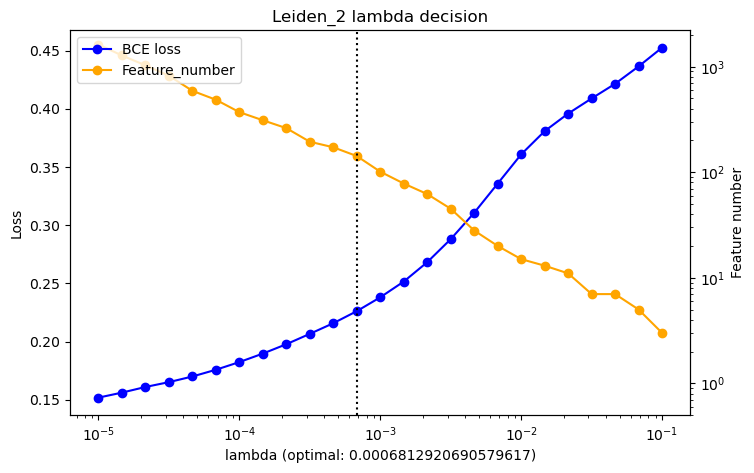

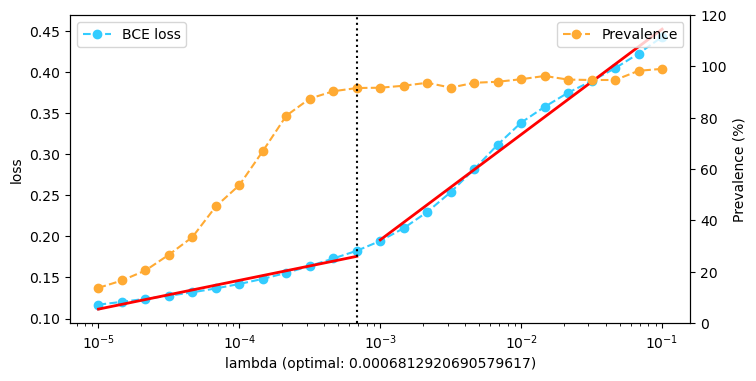

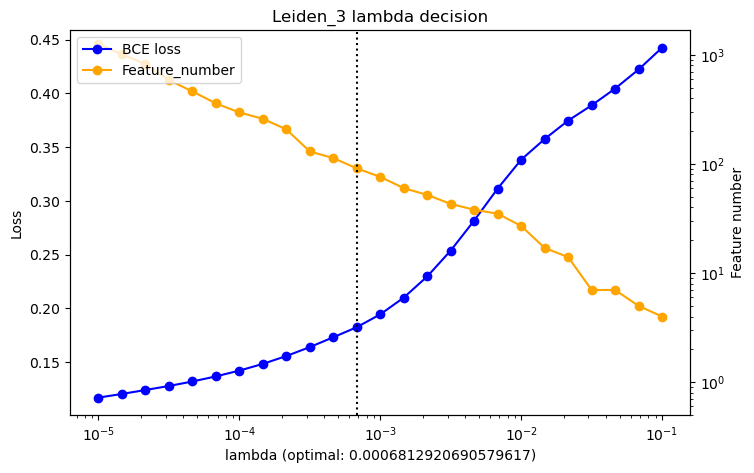

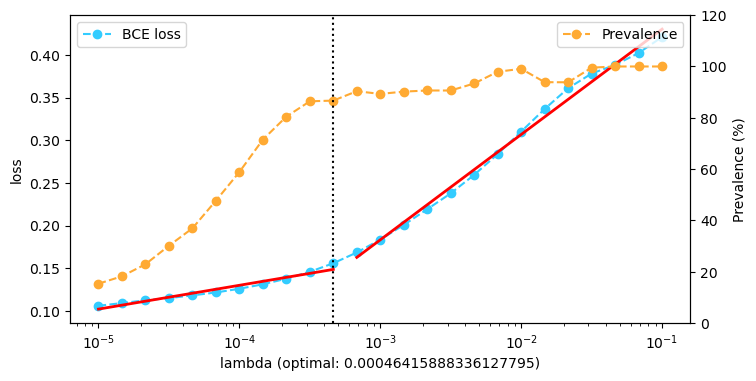

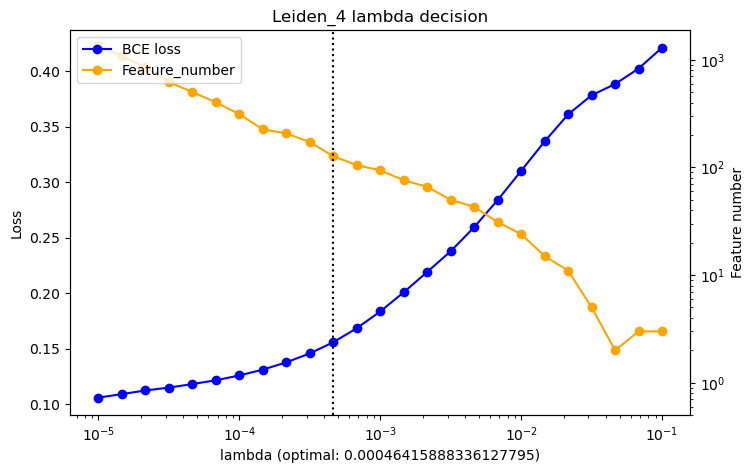

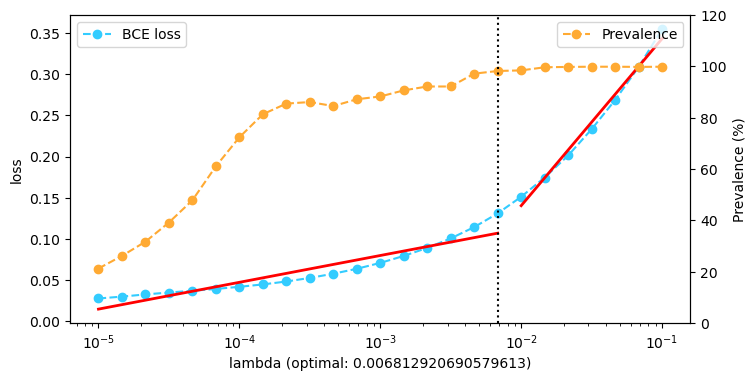

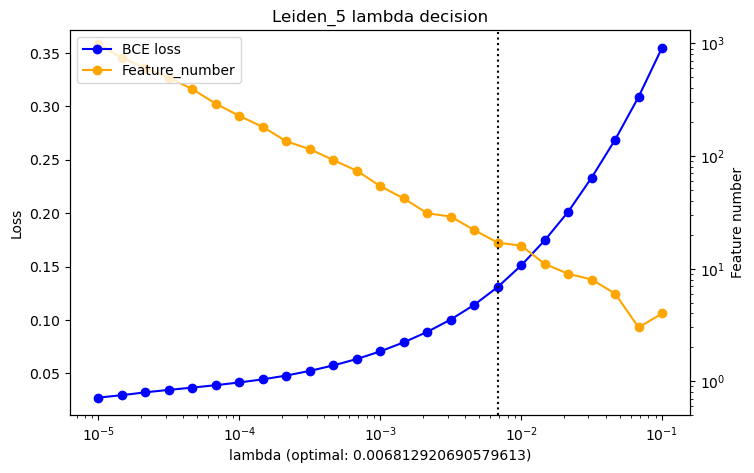

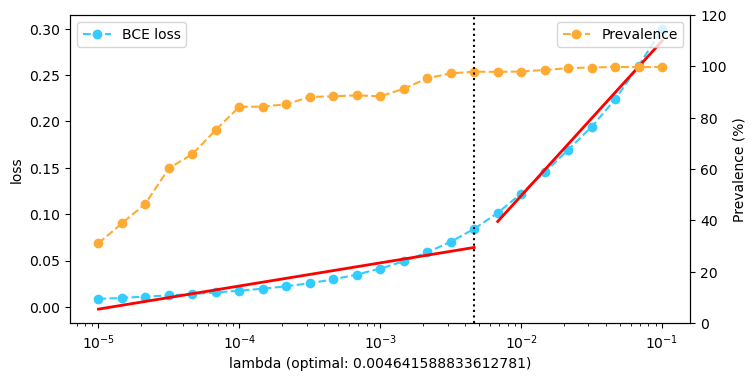

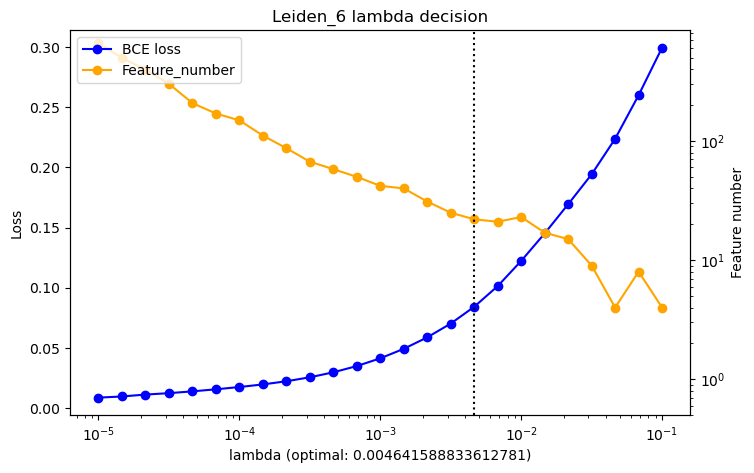

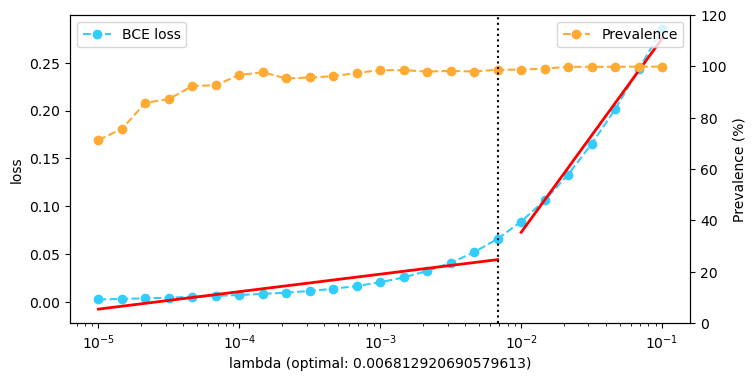

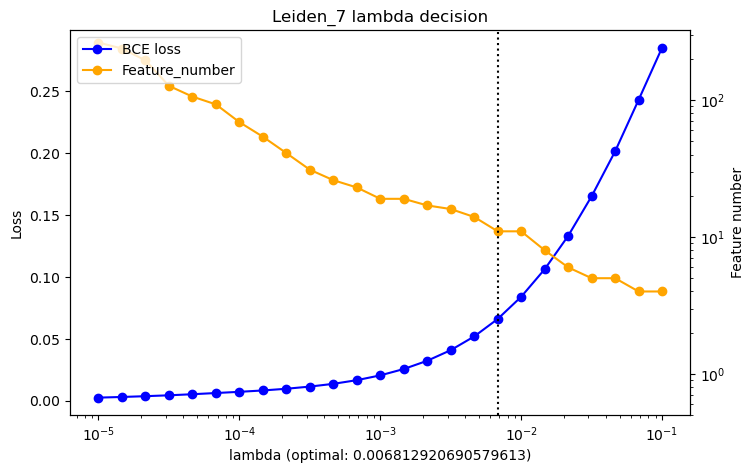

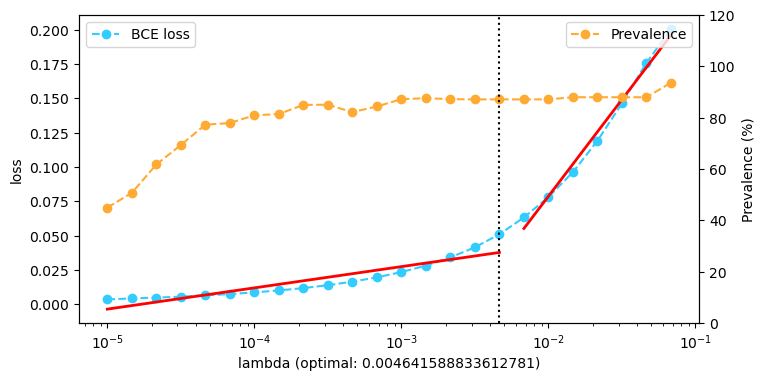

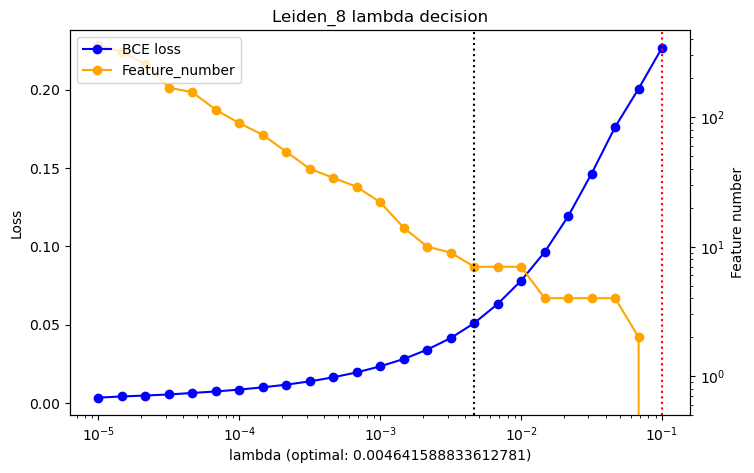

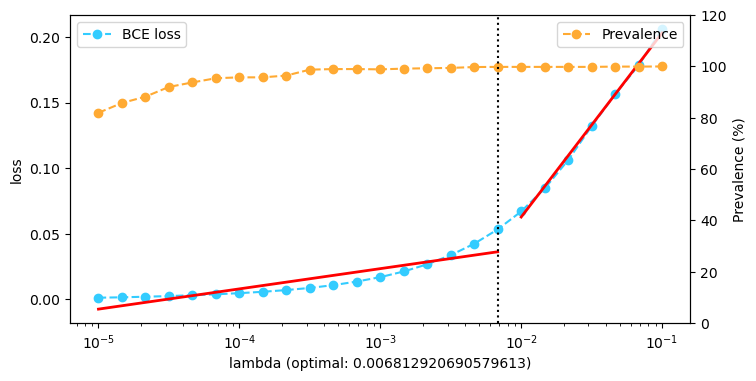

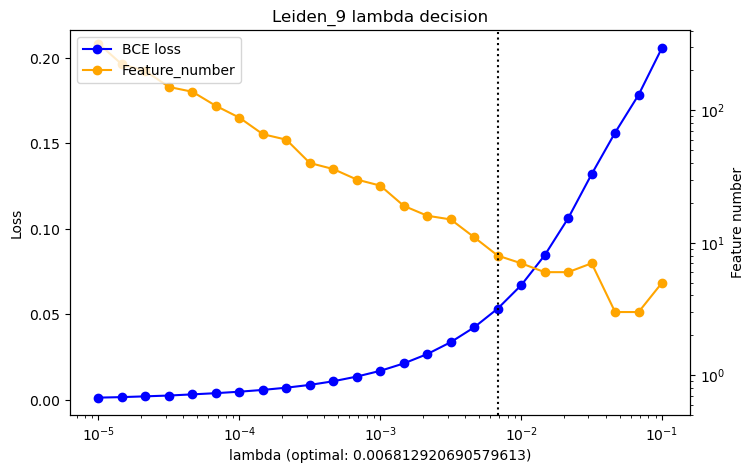

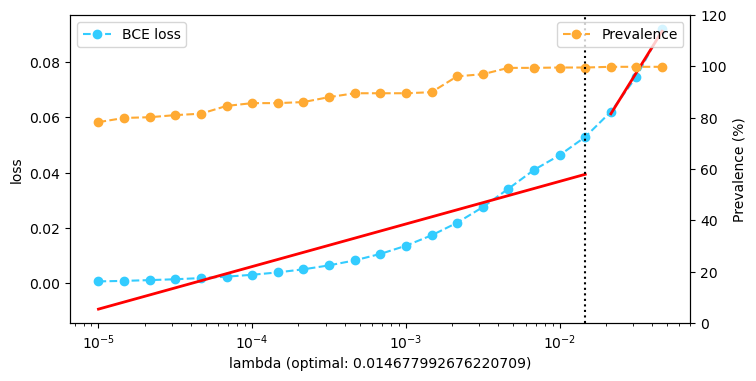

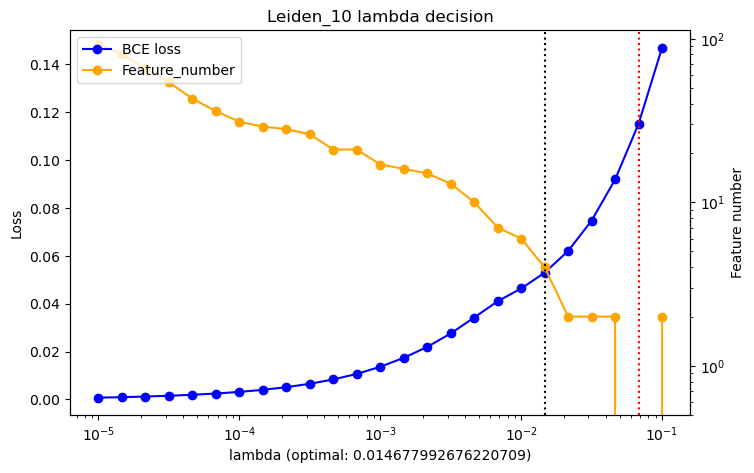

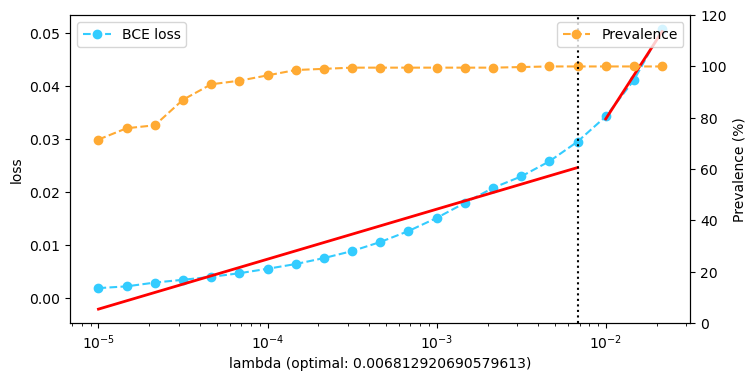

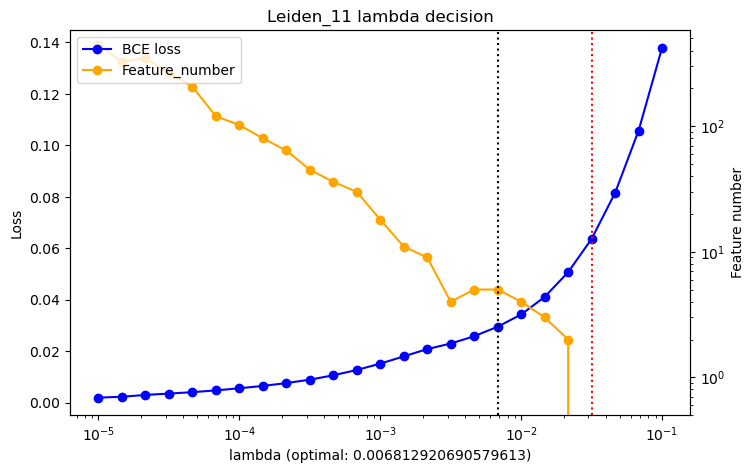

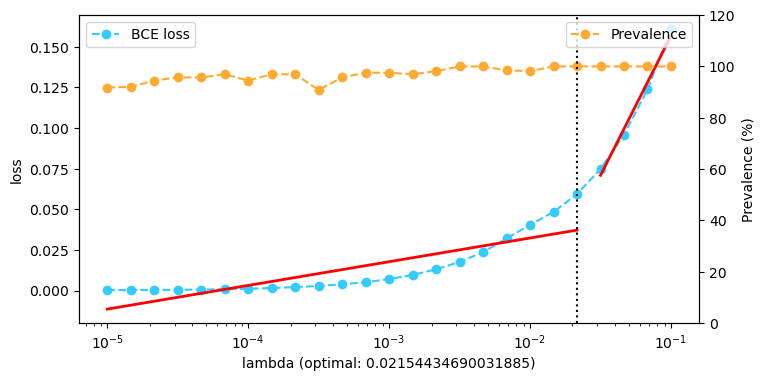

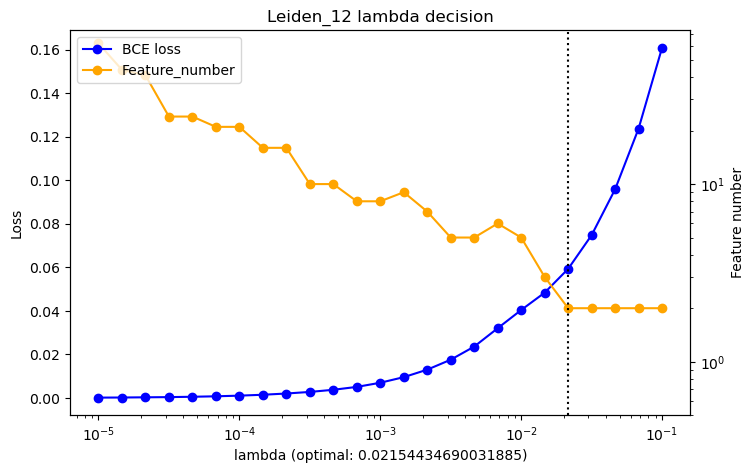

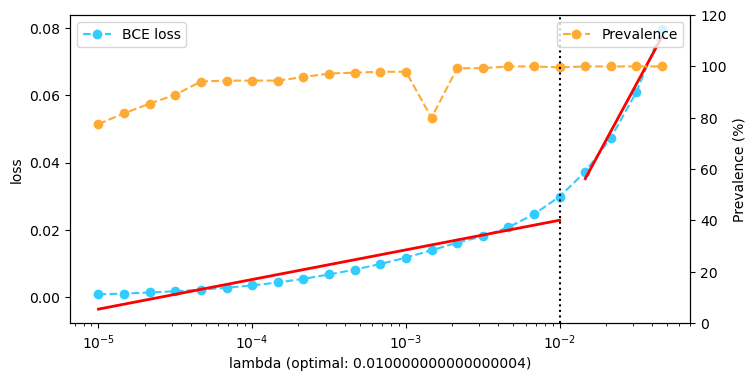

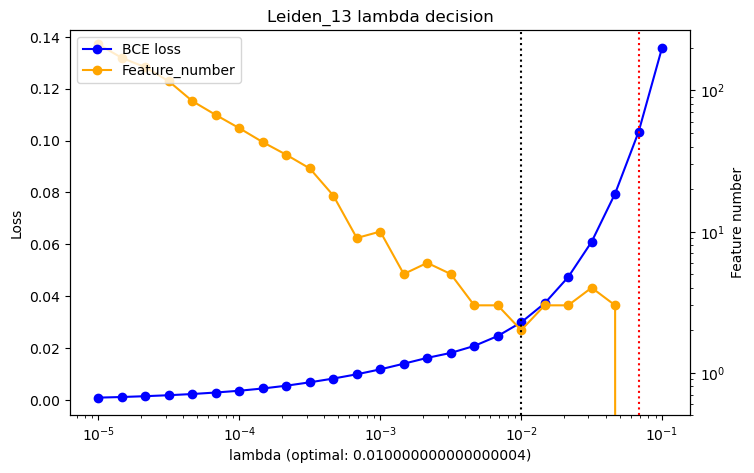

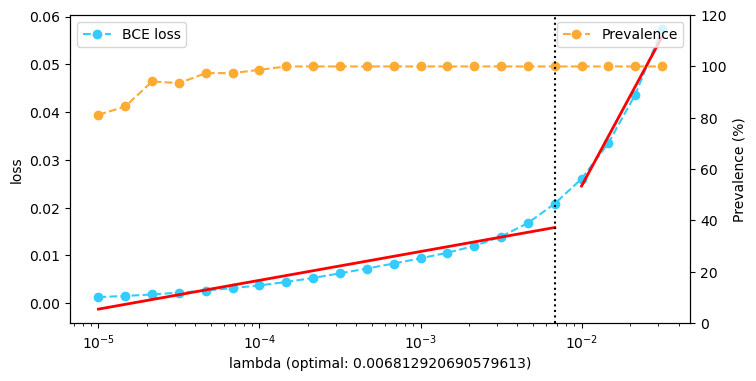

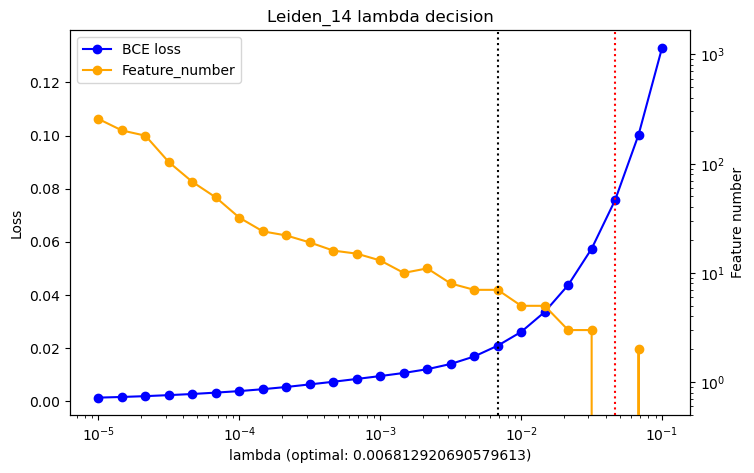

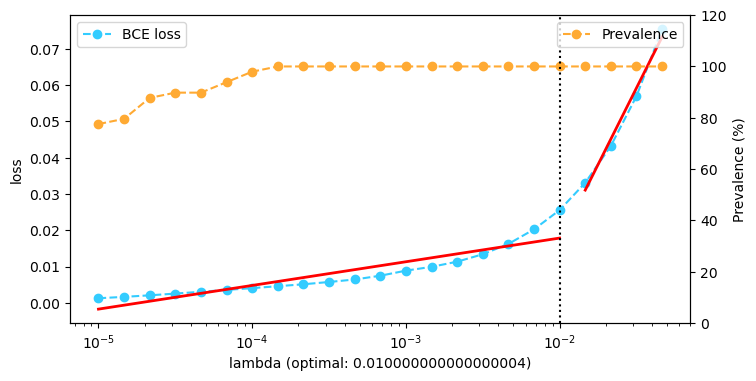

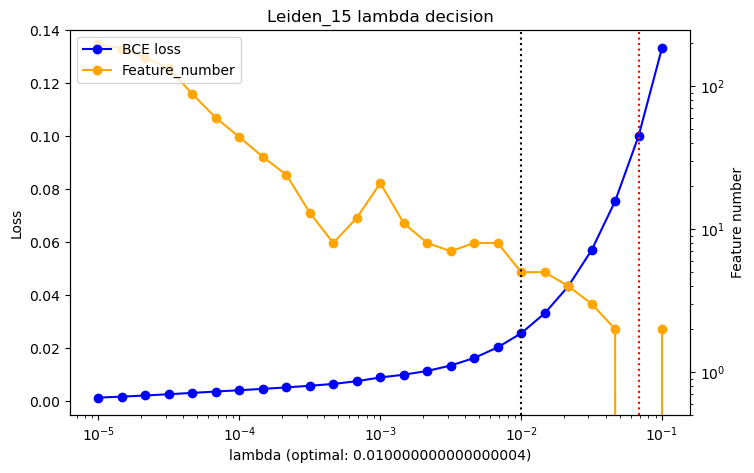

In [5]:
queue = [f'Leiden_{i}' for i in range(0, 16)]

for cluster in queue:
    tuning_file = f'{cluster}_tuning.json'
    if not os.path.exists(tuning_file):
        print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
        continue

    print('====================')
    print(f'Cell type: {cluster}')
    with open(tuning_file) as f:
        tuning = json.load(f)

    output_dir = '/home/jovyan/work/GitHub/EvanPys/Progress/PBMC_Zheng/Leiden_HVG_PreLect/lambda_decision' + '/'
    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, cluster, version='old', output_dir=output_dir)
    opt_lmbd_dict[cluster] = opt_lmbd
    feature_no_dict[cluster] = feature_no_celltype

In [6]:
opt_lmbd_dict

{'Leiden_0': 0.0010000000000000002,
 'Leiden_1': 0.003162277660168382,
 'Leiden_2': 0.0006812920690579617,
 'Leiden_3': 0.0006812920690579617,
 'Leiden_4': 0.00046415888336127795,
 'Leiden_5': 0.006812920690579613,
 'Leiden_6': 0.004641588833612781,
 'Leiden_7': 0.006812920690579613,
 'Leiden_8': 0.004641588833612781,
 'Leiden_9': 0.006812920690579613,
 'Leiden_10': 0.014677992676220709,
 'Leiden_11': 0.006812920690579613,
 'Leiden_12': 0.02154434690031885,
 'Leiden_13': 0.010000000000000004,
 'Leiden_14': 0.006812920690579613,
 'Leiden_15': 0.010000000000000004}

In [7]:
feature_no_dict

{'Leiden_0': 91,
 'Leiden_1': 21,
 'Leiden_2': 142,
 'Leiden_3': 91,
 'Leiden_4': 127,
 'Leiden_5': 17,
 'Leiden_6': 22,
 'Leiden_7': 11,
 'Leiden_8': 7,
 'Leiden_9': 8,
 'Leiden_10': 4,
 'Leiden_11': 5,
 'Leiden_12': 2,
 'Leiden_13': 2,
 'Leiden_14': 7,
 'Leiden_15': 5}

In [8]:
os.chdir('/home/jovyan/work/GitHub/EvanPys/Progress/PBMC_Zheng/Leiden_HVG_PreLect')
with open('Zheng_leiden_opt_lmbd.json', 'w') as f:
    json.dump(opt_lmbd_dict, f)

## Plot feature number

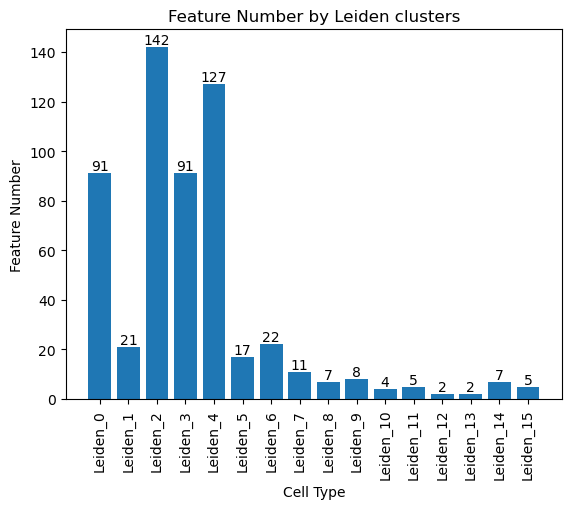

In [10]:
import matplotlib.pyplot as plt

# Extract the cell types and feature numbers from the dictionary
cell_types = list(feature_no_dict.keys())
feature_numbers = list(feature_no_dict.values())

# Create a bar plot
plt.bar(cell_types, feature_numbers)

# Add labels for the y-values on top of each bar
for i, v in enumerate(feature_numbers):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Cell Type')
plt.ylabel('Feature Number')
plt.title('Feature Number by Leiden clusters')
plt.xticks(rotation=90)

# Display the plot
plt.show()
